In [2]:
import os

subj = "Subj1"
exp = "exp_regions"
print_obj = 7
os.makedirs(f"{subj}/{exp}", exist_ok = True)

### Imports

In [18]:
%load_ext autoreload
%autoreload 2

import mne
import tqdm
import scipy
import numpy
import pandas
import scipy.stats
import gtda.curves
import gtda.plotting
import gtda.homology
import gtda.diagrams
import gtda.time_series
import sklearn.decomposition
import matplotlib.pyplot as plt
import matplotlib.patches as ptchs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Features

(32, 3)


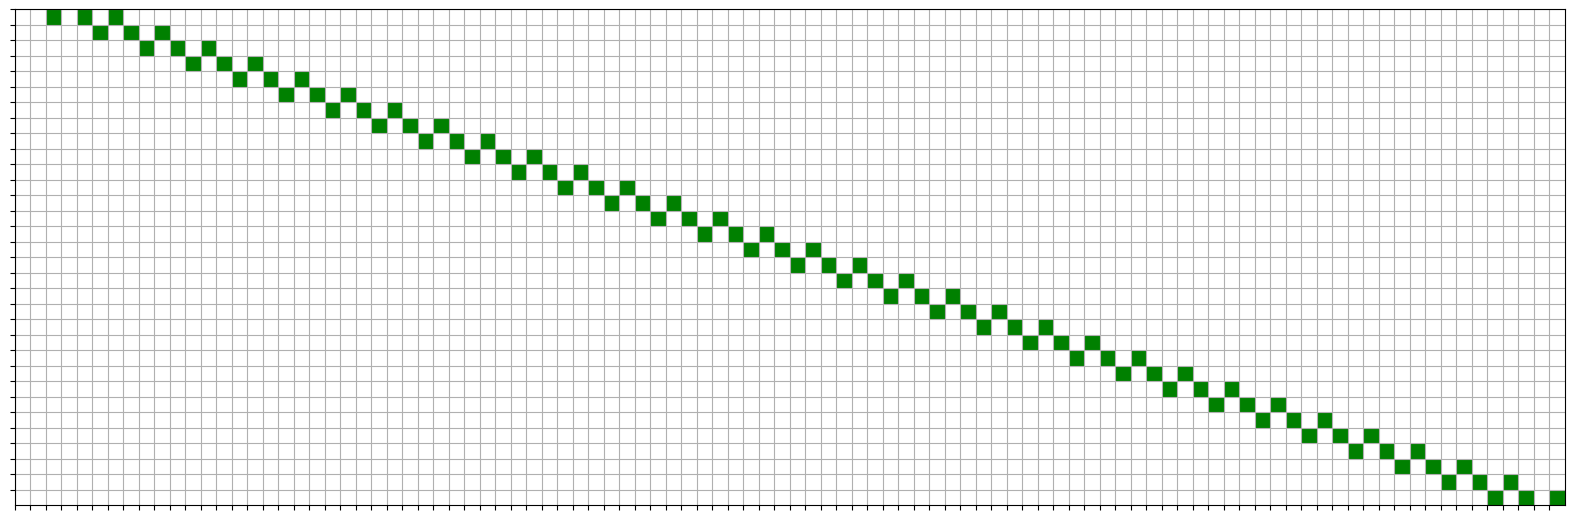

In [53]:
def draw(time_delay, dimension, stride, res = 100):
    data = numpy.arange(res)
    embedder = gtda.time_series.SingleTakensEmbedding(time_delay = time_delay, dimension = dimension, stride = stride)
    points = embedder.fit_transform(data)
    print(points.shape)
    fig, ax = plt.subplots(1, 1, figsize = (20, 100))
    ax.grid()
    ax.set_aspect('equal')
    ax.set_xlim(0, res)
    ax.set_ylim(points.shape[0], 0)
    ax.set_xticks(data)
    ax.set_yticks(numpy.arange(points.shape[0]))
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    for i in range(points.shape[0]):
        for item in points[i]:
            rect = ptchs.Rectangle((item, i), 1, 1, facecolor = 'green')
            ax.add_patch(rect)

draw(2, 3, 3)

In [89]:
def calc_features(data):
    embedder = gtda.time_series.TakensEmbedding(time_delay = 2, dimension = 3, stride = 3)
    points = embedder.fit_transform(data)

    persistence = gtda.homology.VietorisRipsPersistence(homology_dimensions = [0, 1], n_jobs = -1)
    raw_diagram = persistence.fit_transform(points)
    

    scaler = gtda.diagrams.Scaler()
    filtering = gtda.diagrams.Filtering()
    diagram = scaler.fit_transform(raw_diagram)
    diagram = filtering.fit_transform(diagram)

    landscape_features = gtda.diagrams.PersistenceLandscape().fit_transform(diagram)
    landscape_features = gtda.curves.StandardFeatures('argmax').fit_transform(landscape_features)

    betti_features = gtda.diagrams.BettiCurve().fit_transform(diagram)
    betti_features = gtda.curves.Derivative().fit_transform(betti_features)
    betti_features = gtda.curves.StandardFeatures('max').fit_transform(betti_features)

    entropy_features = gtda.diagrams.PersistenceEntropy(normalize = True).fit_transform(diagram)

    number_of_points_features = gtda.diagrams.NumberOfPoints().fit_transform(diagram)

    amplitude_features = [ ]
    for metric in [ 'bottleneck', 'wasserstein', 'betti', 'landscape', 'silhouette', 'heat' ]:
        amplitude_features.append(gtda.diagrams.Amplitude(metric = metric).fit_transform(diagram))
    amplitude_features = numpy.concatenate(amplitude_features, axis = 1)

    pd_ft_life = diagram[:, :, 1] - diagram[:, :, 0]
    life_features = numpy.stack([
        numpy.max(pd_ft_life, axis = 1),
        numpy.mean(pd_ft_life, axis = 1),
        numpy.std(pd_ft_life, axis = 1),
        numpy.percentile(pd_ft_life, 25, axis = 1),
        numpy.median(pd_ft_life, axis = 1),
        numpy.percentile(pd_ft_life, 75, axis = 1),
        scipy.stats.kurtosis(pd_ft_life, axis = 1),
        scipy.stats.skew(pd_ft_life, axis = 1),
        numpy.sum(pd_ft_life, axis = 1),
        numpy.linalg.norm(pd_ft_life, axis = 1)
    ], axis = 1)

    pd_ft_bd2 = (diagram[:, :, 0] + diagram[:, :, 1]) / 2.0
    bd2_features = numpy.stack([
        numpy.max(pd_ft_bd2, axis = 1),
        numpy.mean(pd_ft_bd2, axis = 1),
        numpy.std(pd_ft_bd2, axis = 1),
        numpy.percentile(pd_ft_bd2, 25, axis = 1),
        numpy.median(pd_ft_bd2, axis = 1),
        numpy.percentile(pd_ft_bd2, 75, axis = 1),
        scipy.stats.kurtosis(pd_ft_bd2, axis = 1),
        scipy.stats.skew(pd_ft_bd2, axis = 1),
        numpy.sum(pd_ft_bd2, axis = 1),
        numpy.linalg.norm(pd_ft_bd2, axis = 1)
    ], axis = 1)

    return numpy.concatenate([
        landscape_features,
        betti_features,
        entropy_features,
        number_of_points_features,
        amplitude_features,
        life_features,
        bd2_features
    ], axis = 1)

### Epochs

Reading d:\HSE\year-3\HSE\CourseProject\Subj1\src\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1046 matching events found
No baseline correction applied
0 projection items activated
No projector specified for this dataset. Please consider the method self.add_proj.


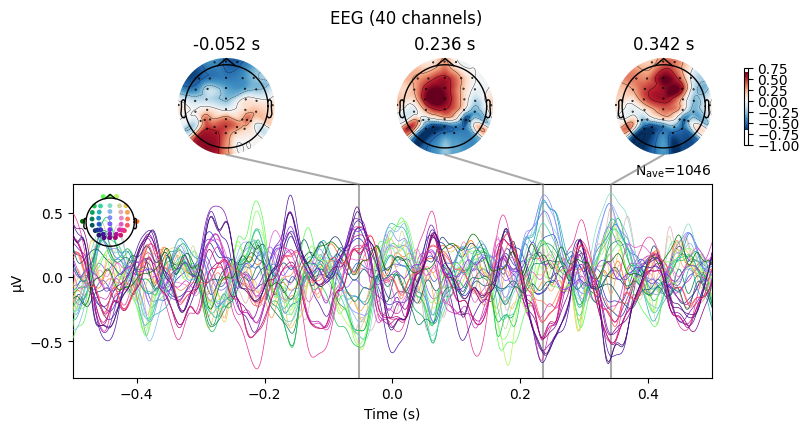

In [54]:
epochs = mne.read_epochs(f"{subj}/src/epochs_filt_rr-epo.fif")
g = epochs.average().plot_joint().savefig(f"{subj}/{exp}/eeg.svg")

### Features

In [80]:
data = epochs.get_data(copy = True)[0, 1, :]
print(data.shape)
embedder = gtda.time_series.SingleTakensEmbedding(parameters_type = 'search', time_delay = 25, dimension = 25)
res = embedder.fit_transform(data)
print(res.shape)
print(embedder.dimension_, embedder.time_delay_)
print(embedder.dimension, embedder.time_delay, embedder.stride)


persistence = gtda.homology.VietorisRipsPersistence(homology_dimensions = [0, 1], n_jobs = -1)
raw_diagram = persistence.fit_transform([ res ])
print(raw_diagram.shape)

plot = gtda.plotting.plot_diagram(raw_diagram[0])
display(plot)

(501,)
(405, 9)
9 12
25 25 1
(1, 511, 3)


In [91]:
regions = [(['Fp1','Fp2','Fpz'], 'Fp', 'Pre-frontal'), (['F7','F3','FT7','FC3'], 'LF', 'Left Frontal'), 
           (['Fz','FCz'], 'MF', 'Midline Frontal'), (['F4','F8','FC4','FT8'], 'RF', 'Right Frontal'),
           (['T3','TP7','T5'], 'LT', 'Left Temporal'), (['T4','TP8','T6'], 'RT', 'Right Temporal'), 
           (['C3','CP3'], 'LC', 'Left Central'), (['Cz','CPz'], 'MC', 'Midline Central'), (['C4','CP4'], 'RC', 'Right Central'),
           (['P3','P5'], 'LP', 'Left Parietal'), (['Pz'], 'MP', 'Midline Parietal'), (['P4','P6'], 'RP', 'Right Parietal'), 
           (['PO3','PO7','O1'], 'LO', 'Left Occipital'), (['POz','Oz'], 'MO', 'Midline Occipital'), 
           (['PO4','PO8','O2'], 'RO', 'Right Occipital')]
region_masks = [ [ ch_name in reg for ch_name in epochs.ch_names ] for (reg, _, _) in regions]

In [92]:
features = [ ]
for (reg, _, _) in tqdm.tqdm(regions):
    mask = [ ch_name in reg for ch_name in epochs.ch_names ]
    data = epochs.get_data(copy = True)[:, mask, :]
    features.append(calc_features(data))

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:41<00:00,  2.76s/it]


In [93]:
features = numpy.concatenate(features, axis = 1)
features.shape

(1046, 600)

### PCA

In [96]:
N_COMP = 0.95
pca = sklearn.decomposition.PCA(n_components = N_COMP, random_state = 0)
pca_features = pca.fit_transform(features)

print(pca_features.shape)
print('Explained variance', round(pca.explained_variance_ratio_.sum(), 2))
print([ round(x, 3) for x in pca.explained_variance_ratio_ ])

(1046, 21)
Explained variance 0.95
[0.406, 0.271, 0.126, 0.047, 0.016, 0.015, 0.01, 0.007, 0.005, 0.005, 0.005, 0.004, 0.004, 0.004, 0.004, 0.004, 0.003, 0.003, 0.003, 0.003, 0.003]


### Save

In [97]:
df = pandas.DataFrame(pca_features)
df.to_feather(f"{subj}/{exp}/features.feather")
df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,8.847377,-4.016451,-61.969872,-95.275093,52.928558,-1.291013,36.163932,-8.965759,-21.090545,35.645368,...,-3.526950,-1.215692,12.030095,11.011627,6.505370,-6.811426,19.361669,-7.282547,-2.789204,36.583829
1,13.445247,-2.689382,-64.283438,-96.795876,51.592194,6.107595,50.449724,-39.089118,-24.451973,44.192448,...,3.124952,-16.376922,51.087044,20.527771,-10.236448,1.222991,-9.906664,12.248852,-6.134075,27.561759
2,12.908029,-3.277698,-74.280787,-114.357238,21.614997,24.005922,16.910543,4.235623,9.726376,1.862521,...,2.215603,-14.089287,8.413810,23.131829,12.542008,-5.414404,-2.057474,1.000680,11.337565,9.285104
3,7.608463,-2.391955,-113.397554,-88.160057,18.036385,1.185099,28.955233,-27.634314,19.936958,15.271176,...,29.205029,-4.917952,52.644953,6.142036,-10.117352,13.578513,-3.865928,-15.979548,5.747301,13.043356
4,10.311709,-4.055697,-59.182656,-111.914778,63.426524,2.857095,22.658269,0.900566,-4.613810,29.313960,...,20.894098,-6.287272,29.693501,-4.240883,-4.967425,18.989474,14.564089,-5.545428,-11.860615,24.303588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,8.096775,-0.868272,-47.068219,114.815747,-0.084687,19.925814,33.416374,-13.797972,-34.597704,-21.596677,...,18.966750,-13.807806,7.113084,14.204717,8.733151,-35.059608,2.493011,-6.766365,24.590823,32.096429
1042,9.563051,0.603142,-64.742229,146.274716,20.086640,27.442435,62.747348,12.431653,-21.612463,4.733085,...,-9.384092,-21.901677,-16.714553,3.382169,20.305097,-30.491251,-1.695099,-3.424006,27.848378,7.519928
1043,47.634150,-3.047847,7.592097,13.822040,-43.062603,24.744937,16.319650,-0.583771,1.567183,0.091745,...,33.071118,-16.569142,-19.659994,10.086866,4.000375,-2.897365,-24.183573,13.623421,4.600639,20.958768
1044,5.496078,-4.095504,42.217944,-10.089893,-33.415309,19.667627,25.785302,17.915898,-16.221369,-8.248345,...,6.424340,2.504069,-8.383155,30.809195,-13.886724,11.989083,5.187752,-15.928666,20.752475,-0.385417
